<a href="https://colab.research.google.com/github/mldessu/projetsimu/blob/main/Chaleur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Équation considérée

Nous partons de l’équation de diffusion thermique :

$$
C_v\,\rho \,\frac{\partial T(x,t)}{\partial t}
\;=\;
k\,\frac{\partial^2 T(x,t)}{\partial x^2}
\;+\;
S(x),
$$

où :

- $T(x,t)$ est la température dans le mur,  
- $C_v$ est la capacité thermique massique,  
- $\rho$ la masse volumique,  
- $k$ la conductivité thermique,  
- $S(x)$ un terme source (ex. chauffage volumique interne).



## 2. Conditions aux limites en forme générale

### 2.1. Condition de Robin (convection) à \(x=0\)

La forme **générale** est :

$$
c_1\,\frac{\partial T}{\partial x}\Big|_{x=0}
\;+\;
c_2\,T(0,t)
\;+\;
c_3
\;=\;
0.
$$

Ici, nous avons :
$$
-\,k\,\frac{\partial T}{\partial x}(0,t)
\;=\;
h\,\bigl(T_a - T(0,t)\bigr)
$$
ce qui se réécrit :
$$
\underbrace{(-k)}_{c_1} \,\frac{\partial T}{\partial x}(0,t)
\;+\;
\underbrace{(h)}_{c_2}\,T(0,t)
\;+\;
\underbrace{(-h\,T_a)}_{c_3}
\;=\;
0.
$$

### 2.2. Condition de Dirichlet (température imposée) à \(x=L\)

Pour imposer \(T(L,t) = T_i\), la forme générale serait :

$$
d_1\,\frac{\partial T}{\partial x}\Big|_{x=L}
\;+\;
d_2\,T(L,t)
\;+\;
d_3
\;=\;
0,
$$


Les **conditions aux limites** sont :

- **À \( x=0 \) (face externe)** :  
$$
-k\,\frac{\partial T(0,t)}{\partial x} = h\,\bigl(T_a-T(0,t)\bigr),\quad \text{avec } h = 1\,\mathrm{W/(m^2\,K)}.
$$

- **À \( x=L \) (face interne)** :  
  $$
  T(L,t) = T_i = 20^\circ\text{C}.
  $$

La **condition initiale** est donnée par :

$$
T(x,0) = T_w + \bigl(T_i - T_w\bigr)\frac{x}{L},
$$

avec

$$
T_w = \frac{T_i\,\frac{k}{L} + T_a\,h}{\frac{k}{L} + h}.
$$

## 3. Source de Chaleur

Nous considérons **une source de chaleur ayant un profil gaussien** (code de références). Celle-ci est définie par :

$$
S(x) = q\,\exp\left(-\left(\frac{x-L}{dL}\right)^2\right),
$$

avec \( dL = 0.05\,\text{m} \). Ce choix permet de concentrer l'apport de chaleur près de la face interne (\( x=L \)) du mur, évitant ainsi une diffusion trop large de la chaleur.

## 4. Méthode implicite 

Pour simuler l’évolution temporelle vers l’état stationnaire, nous utilisons un schéma implicite. Le domaine spatial \([0,L]\) est discrétisé uniformément avec un pas

$$
dx = 0.003\,\text{m},
$$

et le temps est discrétisé en pas \( dt \) on a, dt = $\frac{\rho\,C\,dx^2}{2k}$  de sorte à garantir la stabilité numérique.

Pour discrétiser l'évolution temporelle, nous utilisons un schéma implicite basé sur la formulation générale :

$$
\frac{C_v\,\rho}{k}\,\frac{T^{p+1} - T^p}{dt} = \xi\,\frac{\partial^2 T^{p+1}}{\partial x^2} + (1-\xi)\,\frac{\partial^2 T^p}{\partial x^2} + \frac{S(x)}{k}.
$$

- Ici, nous choisissons $\xi = 1$ c'est-à-dire $\epsilon = 1$, ce qui correspond au schéma d'Euler implicite  où toute la contribution de la diffusion est évaluée au temps $t_{p+1}$.

La discrétisation de l’opérateur de diffusion par différences finies conduit à la formulation matricielle :

$$
A\,T^{p+1} = b,
$$

où la matrice \( A \) intègre la discrétisation en différences centrées de la dérivée seconde ainsi que les conditions aux limites (Robin en  x=0) et Dirichlet en \( x=L \)), et le vecteur \( b \) intègre la contribution de la solution précédente et du terme source.

À chaque pas de temps, nous résolvons ce système linéaire pour obtenir $T^{p+1}$ et nous continuons la simulation jusqu’à ce que la différence entre deux itérations successives soit inférieure à une tolérance fixée, indiquant que l'état stationnaire est atteint.



Le code Python correspondant, qui met en œuvre cette méthode en considérant une source de chaleur de profil gaussien, est présenté dans la cellule suivante.

Équilibre atteint à t = 4644.0 secondes


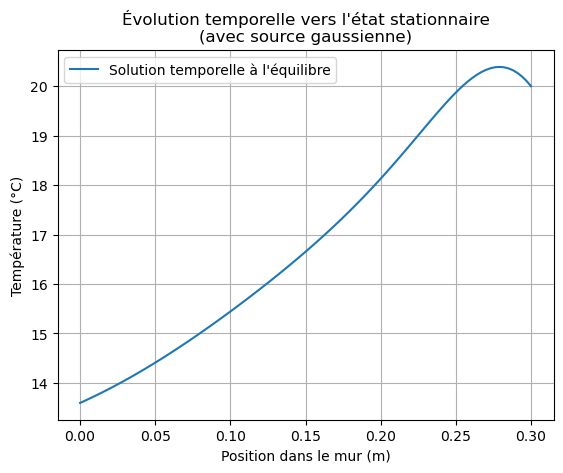

Température maximale à l'équilibre : 20.388658047595477


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Paramètres physiques et géométriques
L   = 0.3        # Épaisseur du mur (m)
T_i = 20.0       # Température intérieure (°C)
T_a = -10.0      # Température extérieure (°C)
q   = 2000.0     # Taux volumique d'émission de chaleur (W/m³)
k   = 1.0        # Conductivité thermique (W/(m·K))
h   = 1.0        # Coefficient de convection (W/(m²·K))
C   = 1000.0     # Capacité thermique spécifique (J/(kg·K))
rho = 2000.0     # Densité (kg/m³)
dL  = 0.05       # Paramètre caractéristique pour la source

# ------------------------------
# 2. Discrétisation spatiale et temporelle
dx = 0.003                         # Pas spatial (m)
N  = int(L / dx)                   # Nombre d'intervalles (N+1 points)
x  = np.linspace(0, L, N+1)          # Coordonnées spatiales

# Pas de temps (choisi pour garantir la stabilité)
dt = (rho * C * dx**2) / (2 * k)
num_steps = 100000                 # Nombre maximal de pas de temps

# ------------------------------
# 3. Condition initiale
# Calcul de T_w et distribution linéaire initiale :
T_w = (T_i * (k / L) + T_a * h) / ((k / L) + h)
T = T_w + (T_i - T_w) * (x / L)

# ------------------------------
# 4. Définition de la source de chaleur (profil gaussien)
S = q * np.exp(-((x - L) / dL)**2)
# Cette forme concentre la chaleur près de x=L (face interne)

# ------------------------------
# 5. Construction de la matrice pour le schéma implicite
# Pour les nœuds intérieurs (i=1,...,N-1) : discrétisation par différences centrales
A_time = np.zeros((N+1, N+1))
lam = k * dt / (rho * C * dx**2)
for i in range(1, N):
    A_time[i, i-1] = -lam
    A_time[i, i]   = 1 + 2 * lam
    A_time[i, i+1] = -lam

# Conditions aux limites :
# À x=0 (face externe) : condition convective (Robin)
# Approximation d'ordre 2 pour T'(0) : (-3T_0 + 4T_1 - T_2) / (2dx)
A_time[0, 0] = 3 * k / (2 * dx) + h
A_time[0, 1] = -4 * k / (2 * dx)
A_time[0, 2] = k / (2 * dx)
# À x=L (face interne) : condition de Dirichlet
A_time[-1, :] = 0
A_time[-1, -1] = 1

# ------------------------------
# 6. Simulation temporelle jusqu'à l'état stationnaire
tol = 1e-3  # Tolérance pour le critère de convergence
for step in range(num_steps):
    # Construction du second membre b_time :
    # Pour les nœuds intérieurs
    b_time = T + dt * (S / (rho * C))

    # Conditions aux limites dans b_time :
    # Pour x=0, en reprenant la formulation associée à la condition convective
    b_time[0] = h * T_a * 2 * dx
    # Pour x=L, T(L) = T_i
    b_time[-1] = T_i

    # Résolution du système linéaire A_time * T_new = b_time
    T_new = np.linalg.solve(A_time, b_time)

    # Critère d'arrêt : convergence lorsque ||T_new - T||∞ < tol
    if np.linalg.norm(T_new - T, ord=np.inf) < tol:
        T = T_new
        print("Équilibre atteint à t =", step * dt, "secondes")
        break

    T = T_new.copy()

# ------------------------------
# 7. Affichage du résultat final
plt.figure()
plt.plot(x, T, label="Solution temporelle à l'équilibre")
plt.xlabel("Position dans le mur (m)")
plt.ylabel("Température (°C)")
plt.title("Évolution temporelle vers l'état stationnaire\n(avec source gaussienne)")
plt.legend()
plt.grid(True)
plt.show()

print("Température maximale à l'équilibre :", T.max())
